In [1]:
"""\
# Copyright (C) 2024 Jesús Bautista Villar <jesbauti20@gmail.com>
"""
!python --version

Python 3.10.12


In [1]:
import os
import numpy as np
from numpy import linalg as LA

# plotting
import matplotlib.pyplot as plt
from seaborn import color_palette

# animations
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.patches as patches

# affine_formations tools
from sf_complex import sim_frame_complex
from sf_affine import sim_frame_affine

# happy pdf for a happy submission without 
# complains in paperplaza, arxiv, etc
import matplotlib

font = {'size' : 16}
matplotlib.rc('font', **font)

## Diagonalization of A

In [146]:
a = 0
omega = 0
hx = 0.5
hy = 0.5

A = a*np.eye(2) + omega*np.array([[0,-1],[1,0]]) + np.array([[0,hx],[hy,0]])
print("A =\n",A,"\n")

# Predicted eigen values and eigenvectors
lambda1 = a + np.sqrt((hx - omega)*(hy + omega) + 0j)
lambda2 = a - np.sqrt((hx - omega)*(hy + omega) + 0j)

denom = np.sqrt(hy + hx + 0j)
v1 = np.array([np.sqrt(hx - omega + 0j),  np.sqrt(hy + omega + 0j)])/denom
v2 = np.array([np.sqrt(hx - omega + 0j), -np.sqrt(hy + omega + 0j)])/denom
V = np.array([v1,v2]).T

print("------- Predicted")
with np.printoptions(precision=3, suppress=True):
    print("lambda_1 = {:.3f} -- ".format(lambda1), v1)
    print("lambda_2 = {:.3f} -- ".format(lambda2), v2)
    print("Diagonalization check (A - VDV^-1):\n", A - V@np.array([[lambda1,0],[0,lambda2]])@LA.inv(V))
# print((A - lambda1*np.eye(2))@v1[:,None])
# print((A - lambda2*np.eye(2))@v2[:,None])

# Comparing with the computed eigen values and eigenvectors
print("------- Computed")
lambdas, vs = LA.eig(A)
with np.printoptions(precision=3, suppress=True):
    print("lambdas: ", lambdas)
    print("v1 = ", vs[:,0])
    print("v2 = ", vs[:,1])

A =
 [[0.  0.5]
 [0.5 0. ]] 

------- Predicted
lambda_1 = 0.500+0.000j --  [0.707+0.j 0.707+0.j]
lambda_2 = -0.500+0.000j --  [ 0.707+0.j -0.707+0.j]
Diagonalization check (A - VDV^-1):
 [[-0.+0.j  0.+0.j]
 [ 0.+0.j -0.+0.j]]
------- Computed
lambdas:  [ 0.5 -0.5]
v1 =  [0.707 0.707]
v2 =  [-0.707  0.707]


### Differential equation 
$$\dot x(t) = A x(t) \quad \Longrightarrow \quad x(t) = e^{At}x(0)$$

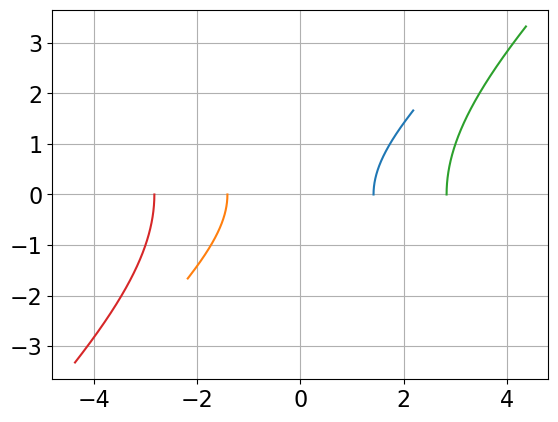

In [163]:
## Analytical solution
tf = 2
t = np.linspace(0,tf,1000)[:,None]
v1 = v1.reshape(2,1)
v2 = v2.reshape(2,1)

fig, ax = plt.subplots()

c_list = ((1,0),(-1,0),(2,2),(-2,2))
for c_pair in c_list:
    c1 = c_pair[0]
    c2 = c_pair[0]

    x =  c1*np.squeeze(np.exp(lambda1.real*t))*(np.real(v1)*np.cos(lambda1.imag*t).T + \
                                                np.imag(v1)*np.sin(lambda1.imag*t).T)  \
        +c2*np.squeeze(np.exp(lambda2.real*t))*(np.real(v2)*np.cos(lambda2.imag*t).T + \
                                                np.imag(v2)*np.sin(lambda2.imag*t).T)
    ax.plot(x[0,:], x[1,:])

ax.grid(True)
plt.show()

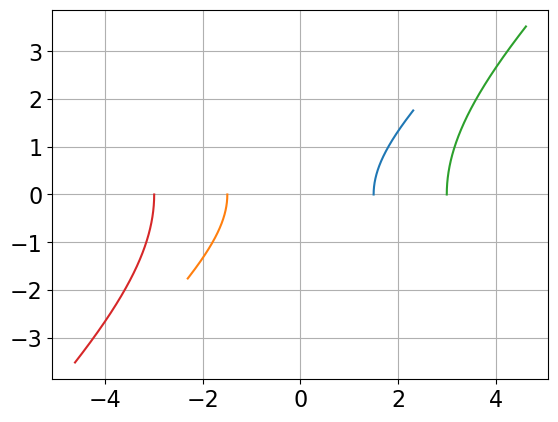

In [185]:
## Euler integration
tf = 2
dt = tf/1000
its = int(tf/dt)

fig, ax = plt.subplots()

x0_list = [[1.5,0], [-1.5,0], [3,0], [-3,0]]
for x0 in x0_list:
    x_data = []
    x = np.array(x0)[:,None]
    for it in range(its):
        x_data.append(x)
        x = x + A@x*dt
    x_data = np.squeeze(np.array(x_data)).T
    ax.plot(x_data[0,:], x_data[1,:])

ax.grid(True)
plt.show()

## Diagonalization of $(I_n \otimes A)$

In [55]:
LA.eig(np.eye(4))

(array([1., 1., 1., 1.]),
 array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]))

In [50]:
m = 2
A_bar = np.kron(np.eye(m),A)

# Predicted eigen values and eigenvectors
lambda1 = a + np.sqrt((hx - omega)*(hy + omega) + 0j)
lambda2 = a - np.sqrt((hx - omega)*(hy + omega) + 0j)

denom = np.sqrt(hy + omega + hx - omega + 0j)
v1 = np.array([np.sqrt(hx - omega + 0j),  np.sqrt(hy + omega + 0j)])/denom
v2 = np.array([np.sqrt(hx - omega + 0j), -np.sqrt(hy + omega + 0j)])/denom

e1 = np.array([1,0])
e2 = np.array([0,1])

u1 = np.kron(np.ones(2),v1)
u2 = np.kron(np.ones(2),v2)

print("------- Predicted")
with np.printoptions(precision=3, suppress=True):
    print("u_1 = {:.3f} -- ".format(lambda1), v1)
    print("u_2 = {:.3f} -- ".format(lambda2), v2)

# Comparing with the computed eigen values and eigenvectors
print("------- Computed")
lambdas_c, V_c = LA.eig(A_bar)
with np.printoptions(precision=3, suppress=True):
    print("lambdas: ", lambdas_c)
    print("V = \n", V_c)

------- Predicted
lambda_1 = 1.000+1.732j --  [0.   +0.707j 1.225+0.j   ]
lambda_2 = 1.000-1.732j --  [ 0.   +0.707j -1.225+0.j   ]
Diagonalization check (A - VDV^-1):
 [[ 0.+0.j -0.+0.j]
 [ 0.+0.j  0.+0.j]]
------- Computed
lambdas:  [1.+1.732j 1.-1.732j 1.+1.732j 1.-1.732j]
V = 
 [[0.   +0.5j 0.   -0.5j 0.   +0.j  0.   -0.j ]
 [0.866+0.j  0.866-0.j  0.   +0.j  0.   -0.j ]
 [0.   +0.j  0.   -0.j  0.   +0.5j 0.   -0.5j]
 [0.   +0.j  0.   -0.j  0.866+0.j  0.866-0.j ]]
